In [26]:
# add autoreload
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import sys
from collections import defaultdict
from tqdm import tqdm

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
from keras.utils import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer as KerasTokenizer
from keras.models import Sequential
from keras import layers, utils
from keras import optimizers

import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
import gc

from typing import Tuple, Dict, List, Literal

In [28]:
os.chdir('T://lab_research/RES-Folder-UPOD/Echo_label/E_ResearchData/2_ResearchData')

In [29]:
print("The possible classes are:")
print(20*"---")
print([c.split(".")[0] for c in os.listdir('./echo_doc_labels')])

The possible classes are:
------------------------------------------------------------
['aortic_regurgitation', 'aortic_stenosis', 'diastolic_dysfunction', 'lv_dil', 'lv_syst_func', 'merged_labels', 'mitral_regurgitation', 'pe', 'rv_dil', 'rv_syst_func', 'tricuspid_regurgitation', 'wma']


In [30]:
#  settings
embedding_dim = 128
max_len = 200
num_words_in_vocab = 5_000
num_epochs = 50
num_folds = 10
Class = 'pe' # aortic_regurgitation, lv_sys_func, None to run all  
batch_size = 128
ModelType = 'cnn' # bigru, bilstm, cnn
ProcessorType = "cpu" if len(tf.config.experimental.list_physical_devices("GPU"))==0 else "gpu"
Splitting = 'from_file' # CV or from_file
UseClassWeights = False
LR = 0.0005
dilation=2
num_layers = 128

In [31]:
print(ProcessorType)

cpu


In [32]:
plt.style.use('ggplot')

In [33]:
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(probs, labels, threshold=0.5):
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    
    y_true = labels
    #y_true = tf.keras.backend.eval(y_true)
    #y_pred = tf.keras.backend.eval(y_pred)
    
    f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
    f1_weighted = f1_score(y_true=y_true, y_pred=y_pred, average='weighted')
    f1_micro = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    prec_macro = precision_score(y_true=y_true, y_pred=y_pred, average='macro')
    prec_weighted = precision_score(y_true=y_true, y_pred=y_pred, average='weighted')
    prec_micro = precision_score(y_true=y_true, y_pred=y_pred, average='micro')
    recall_macro = recall_score(y_true=y_true, y_pred=y_pred, average='macro')
    recall_weighted = recall_score(y_true=y_true, y_pred=y_pred, average='weighted')
    recall_micro = recall_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc_weighted = roc_auc_score(y_true, probs, average = 'weighted')
    roc_auc_macro = roc_auc_score(y_true, probs, average = 'macro')
    roc_auc_micro = roc_auc_score(y_true, probs, average = 'micro')

    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1_macro': f1_macro,
               'f1_weighted': f1_weighted,
               'f1_micro': f1_micro,
               'prec_macro': prec_macro,
               'prec_weighted': prec_weighted,
               'prec_micro': prec_micro,
               'recall_macro': recall_macro,
               'recall_weighted': recall_weighted,
               'recall_micro': recall_micro,
               'roc_auc_macro': roc_auc_macro,
               'roc_auc_weighted': roc_auc_weighted,
               'roc_auc_micro': roc_auc_micro,
               'accuracy': accuracy}
    return metrics
     


In [34]:
# inference pipe
def tokenize_and_pad(x, tokenizer, maxlen = 256):
    toks = tokenizer.texts_to_sequences(x)
    toks_padded = pad_sequences(toks, padding = 'post', maxlen = maxlen)
    return toks_padded

def evaluate_model(clf, labels):
    probas = clf.predict(X_test)
    cf_matrix = confusion_matrix(np.argmax(labels, axis=1),
                                 np.argmax(probas, axis=1))

    return cf_matrix


In [35]:
# Stratified cross-validation

def fold_indices(targets: pd.Series=None, stratified: bool=True, seed: int=42, numfolds: int=10)->Tuple[List,List]:
    if stratified:
        splitter = StratifiedKFold(n_splits=numfolds, shuffle=True, random_state=seed)
        _Targets = targets
    else:
        splitter = KFold(n_splits=numfolds, shuffle=True, random_state=seed)
        _Targets = None

    train_indcs, test_indcs = [], []
    for train_index, test_index in splitter.split(X=targets, y=_Targets):
        train_indcs.append(train_index)
        test_indcs.append(test_index)

    return zip(train_indcs, test_indcs)

In [36]:
class CustomMetrics(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(CustomMetrics, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = self.model.predict(self.validation_data[0])
        val_targ = self.validation_data[1]

        _val_metrics = multi_label_metrics(val_targ, val_predict)
        for name, value in _val_metrics.items():
            logs['val_' + name] = value

        print(" — val_f1_macro: %f — val_accuracy: %f" % (logs['val_f1_macro'], logs['val_accuracy']))
        return

In [37]:
def CurrentModel(modelselection: Literal['bigru', 'bilstm', 'cnn'], 
                 embeddingdim: int=128, 
                 maxlen: int=256, 
                 vocabsize: int=50_000,
                 numclasses: int=5,
                 learningrate: float=0.001,
                 layers: int=128,
                 dilation=4):
    model = Sequential()
    if modelselection =='bigru':        
        model.add(layers.Embedding(vocabsize, embeddingdim, input_length=maxlen))
        model.add(layers.Bidirectional(layers.GRU(layers)))
        model.add(layers.Dense(10, activation = 'relu'))
        model.add(layers.Dense(numclasses, activation = 'softmax'))
        model.compile(optimizer = optimizers.Adam(learning_rate=learningrate),
                      loss = 'categorical_crossentropy',
                      metrics = ['accuracy'])
    elif modelselection =='bilstm':
        model.add(layers.Embedding(vocabsize, embeddingdim, input_length=maxlen))
        model.add(layers.Bidirectional(layers.LSTM(layers)))
        model.add(layers.Dense(10, activation = 'relu'))
        model.add(layers.Dense(numclasses, activation = 'softmax'))
        model.compile(optimizer = optimizers.Adam(learning_rate=learningrate),
                      loss = 'categorical_crossentropy',
                      metrics = ['accuracy'])
    elif modelselection =='cnn':
        model.add(layers.Embedding(vocabsize, embeddingdim, input_length = maxlen))
        model.add(layers.Conv1D(layers, 5, activation = 'relu', dilation_rate = dilation))
        model.add(layers.GlobalMaxPooling1D())
        model.add(layers.Dense(10, activation = 'relu'))
        model.add(layers.Dense(numclasses, activation = 'softmax'))
        model.compile(optimizer = optimizers.Adam(learning_rate=learningrate),
                      loss = 'categorical_crossentropy',
                      metrics = ['accuracy'])
    return model

In [38]:
def run_model_pipe(x: list, model: Sequential, maxlen: int=256, tokenizer=None):
    x_tok = tokenize_and_pad(x, tokenizer=tokenizer, maxlen=maxlen)
    return model.predict(x_tok)

# Load data

In [39]:
labeled_documents = pd.read_json(f"./echo_doc_labels/{Class}.jsonl", lines=True)
label_col = 'label' if Class!='merged_labels' else 'labels'
target_df = pd.DataFrame.from_records(labeled_documents[label_col])

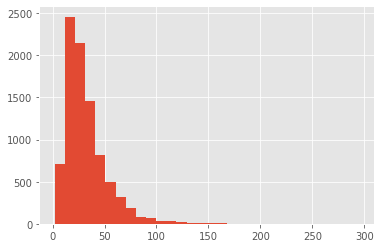

In [40]:
num_tokens = labeled_documents.text.apply(lambda x: len(x.split(" ")))
plt.hist(num_tokens, bins=30);

In [41]:
_set = set()
for __set in labeled_documents.text.apply(lambda x: set(x.split(" "))).values:
    _set = _set.union(__set)
print(f"Number of unique tokens: {len(_set)}")

Number of unique tokens: 26851


In [42]:
# load train/test hashes
hash_docs_link = pd.read_json("./echo_span_labels/reduced_labels/merged_labels.jsonl", lines=True)[['text', '_input_hash']]
train_ids = pd.read_csv('./train_echoid.csv', sep=',').input_hash.unique()
test_ids = pd.read_csv('./test_echoid.csv', sep=',').input_hash.unique()

labeled_documents['_hash'] = labeled_documents.text.str.strip().apply(lambda x: hash(x))
hash_docs_link['_hash'] = hash_docs_link.text.str.strip().apply(lambda x: hash(x))

labeled_documents = labeled_documents.merge(hash_docs_link[['_input_hash', '_hash']], 
                                            on='_hash', how='inner')

labeled_documents = labeled_documents.drop_duplicates(subset=['_hash']).reset_index(drop=True)

In [43]:
labeled_documents

,text,label,_hash,_input_hash
0,Goede functie van R.V. en L.V. Nog bekijken me...,No label,-7147208342686005955,-1492643194
1,Goede L.V. functie en R.V. functie. Er is een ...,No label,-993775260996718635,-1268308324
2,"Normale dimensie LV. prominent basale septum, ...",No label,5871947649668733629,-1752879130
3,Globaal redelijke systolische restfunctie. Voo...,No label,-1795493566149579135,-1692751703
4,Goede systolische LV-functie. Matige cLVH. Gee...,No label,4180023732490429284,570163096
...,...,...,...,...
4994,Ter verbetering van de beeldkwaliteit contrast...,No label,4157667629913284679,968183209
4995,Dimensie aortawortel onveranderd (40mm). Ascen...,No label,-5369320778268416811,-1173085931
4996,Globaal normale dimensie en goede systolische ...,Normal,-5741786870974722620,1471342145
4997,N.B.: mevrouw is vanmorgen gevallen en kan all...,Normal,-6910372989548428468,1345065450


In [44]:
# Expand with label columns
if Class == 'merged_labels':
    Target_maps = {
        _Class: {Label:i for i,Label in enumerate(target_df[Class].unique())}
        for _Class in target_df.columns
    }
else:
    Target_maps = {
        Class: {Label: i for i,Label in enumerate(labeled_documents['label'].unique())} 
    }

In [45]:
if Class == 'merged_labels':
    DF = labeled_documents[['text', '_input_hash']].join(target_df[Class])
else:
    DF = labeled_documents[['text', '_input_hash', 'label']]

DF.columns = ['sentence', '_input_hash', 'labels']

label2id = Target_maps[Class]
id2label = {v:k for k,v in label2id.items()}
num_labels = len(label2id)

DF= DF.assign(label=DF['labels'].map(label2id))

# Make folds

In [46]:
# prepping
TrainTestDict = defaultdict(dict)

if Splitting == 'from_file':
    TrainTestDict[0]['Xtrain'] = DF.loc[DF._input_hash.isin(train_ids)].sentence
    TrainTestDict[0]['Xtest'] = DF.loc[DF._input_hash.isin(test_ids)].sentence
    
    TrainTestDict[0]['ytrain'] = DF.loc[DF._input_hash.isin(train_ids)].labels
    TrainTestDict[0]['ytest'] = DF.loc[DF._input_hash.isin(test_ids)].labels
    
elif Splitting == 'CV':
    for k,(train_index, test_index) in enumerate(fold_indices(targets=DF['labels'], stratified=True)):
        TrainTestDict[k]['Xtrain'] = DF.iloc[train_index].sentence
        TrainTestDict[k]['Xtest'] = DF.iloc[test_index].sentence
        
        TrainTestDict[k]['ytrain'] = DF.iloc[train_index].labels
        TrainTestDict[k]['ytest'] = DF.iloc[test_index].labels
    

## Initiate models

In [47]:
ModelDict = defaultdict(dict)
for k,v in TrainTestDict.items():
    LSTM_Tokenizer = KerasTokenizer(num_words=num_words_in_vocab)
    LSTM_Tokenizer.fit_on_texts(v['Xtrain'])
    
    vocab_size = len(LSTM_Tokenizer.word_index)+1
    num_classes = np.unique(v['ytrain']).shape[0]
    
    ModelDict[k]['tokenizer'] = LSTM_Tokenizer
    ModelDict[k]['model'] = CurrentModel(modelselection=ModelType, 
                                         embeddingdim=embedding_dim,
                                         maxlen=max_len,
                                         vocabsize=vocab_size,
                                         numclasses=num_classes,
                                         learningrate=LR,
                                         dilation=dilation,
                                         layers=num_layers
                                         )

AttributeError: 'int' object has no attribute 'Embedding'

# Train

In [ ]:
ResultDict = defaultdict(lambda: defaultdict(list))
for k,v in ModelDict.items():
    _model =  v['model']
    _tokenizer = v['tokenizer']

    X_train = _tokenizer.texts_to_sequences(TrainTestDict[k]['Xtrain'])
    X_test = _tokenizer.texts_to_sequences(TrainTestDict[k]['Xtest'])

    X_train = pad_sequences(X_train, padding = 'post', maxlen=max_len)
    X_test = pad_sequences(X_test, padding = 'post', maxlen=max_len)

    lb = LabelEncoder()
    _y = lb.fit_transform(TrainTestDict[k]['ytrain'])
    y_train = utils.to_categorical(_y)

    _y = lb.transform(TrainTestDict[k]['ytest'])
    y_test = utils.to_categorical(_y)

    if UseClassWeights:
        PosSum = 1/np.sum(y_train, axis=0)
        ClassWeights = dict(enumerate(PosSum/np.min(PosSum)))
    else:
        ClassWeights = None
    
    result_list = []
    history_list = []
    confusion_list = []
    for epoch_num in range(1, num_epochs+1):
        _history = _model.fit(X_train,
                             y_train,                         
                             epochs = 1,
                             verbose = False,
                             validation_split = 0,
                             class_weight=ClassWeights,
                             batch_size = batch_size)
    
        y_pred = _model.predict(X_test, verbose=False)
        _res = multi_label_metrics(labels=y_test, probs=y_pred)
        
        result_list.append(_res)
        history_list.append({'loss': _history.history['loss'][0], 
                             'accuracy': _history.history['accuracy'][0]})
        confusion_list = {id2label[k]: confusion_matrix(y_test[:,k], np.round(y_pred[:,k]))
                          for k in range(len(id2label.keys()))}
        
        
        print(f"Test: F1 Macro={_res['f1_macro']}")
        
    ResultDict[k]['history'] = pd.DataFrame(history_list)
    ResultDict[k]['result'] = pd.DataFrame(result_list)
    

In [ ]:
(ResultDict[k]['result'])

In [ ]:
plt.plot(ResultDict[k]['result']['f1_macro'], label='F1 Macro')
plt.plot(ResultDict[k]['result']['prec_macro'], label='Precision Macro')
plt.plot(ResultDict[k]['result']['recall_macro'], label='Recall Macro')
plt.legend(loc='best')

## Upload to huggingface hub